In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm # Use notebook version for better display (used in predict_rewards)
from collections import deque # For observation history buffer
import glob # For finding checkpoints
from importnb import Notebook # For importing from other notebooks/scripts
import sys # For exiting gracefully
import cv2 # Needed for image decoding
import base64 # For decoding image from rpyc server
import io # For handling image bytes
import logging # For RemoteJetBot logging
import config
import models
from models import SimpleUNetV1
from transformers import CLIPProcessor, CLIPModel
with Notebook():
    from action_conditioned_diffusion_world_model_gemini import linear_beta_schedule, cosine_beta_schedule, get_index_from_list, forward_diffusion_sample
    from jetbot_remote_client import RemoteJetBot

logger = logging.getLogger('MPC_Client')
logger.setLevel(logging.WARNING)
logging.basicConfig(level=logging.WARNING) # Set logging level (INFO, DEBUG, etc.)
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


In [2]:
# --- JetBot Server Connection ---
JETBOT_SERVER_IP = "192.168.68.62" # <<< --- REPLACE WITH YOUR JETBOT'S ACTUAL IP ADDRESS
# Port identified from jetbot_server.py (uses rpyc)
JETBOT_SERVER_PORT = 18861

# --- Device Setup ---
device = torch.device(config.DEVICE if hasattr(config, 'DEVICE') else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# --- Model Paths ---
# World model path will be determined automatically by searching for 'model_best_epoch_*.pth'.

# Path to fine-tuned CLIP weights (ckpt-final folder)
CLIP_CKPT_PATH = r"C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\clip_kong_finetune\ckpt-final"
# Base model name you started from
CLIP_BASE_NAME = "openai/clip-vit-large-patch14"

# --- MPC Parameters ---
HORIZON = 5             # Planning horizon (number of steps to look ahead) H
N_ACTIONS = 1           # Dimensionality of the action space (RIGHT MOTOR ONLY)

# --- Discrete Actions ---
DISCRETE_ACTIONS = [0.0, 0.1] # The two possible actions

# --- Real Robot Parameters ---
REAL_ROBOT_FRAME_DELAY = 1.0 / 30.0 # Based on 30 FPS assumption
ACTION_SCALE = 1.0 # Keep for potential future use, but actions are discrete now

# --- Image Preprocessing (Matches config.TRANSFORM) ---
IMAGE_CHANNELS = 3 # Assuming 3 channels based on config.TRANSFORM and models
preprocess = transforms.Compose([
    # Note: Image received from get_frame is BGR numpy array.
    # Convert to RGB, then PIL, then transform.
    transforms.ToPILImage(), # Convert numpy array (RGB) to PIL Image
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization from config.TRANSFORM
])
# Inverse transform for visualization
denormalize = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
])

# --- Diffusion Parameters (from config.py or defaults) ---
NUM_TIMESTEPS = getattr(config, 'NUM_TIMESTEPS', 10) # Use config value, default 10 based on log
BETA_START = getattr(config, 'BETA_START', 1e-4) #
BETA_END = getattr(config, 'BETA_END', 0.02) #
SCHEDULE_TYPE = getattr(config, 'SCHEDULE_TYPE', 'linear') #
NUM_PREV_FRAMES = config.NUM_PREV_FRAMES # Number of previous frames model expects

# --- Visualization Buffer ---
VISUALIZATION_BUFFER_SIZE = 50 # Store last N frames for visualization on exit

# %% [markdown]
# ## Diffusion Schedule Setup

# %%
# Calculate betas using imported functions
if SCHEDULE_TYPE == 'linear':
    betas = linear_beta_schedule(NUM_TIMESTEPS, BETA_START, BETA_END)
elif SCHEDULE_TYPE == 'cosine':
    betas = cosine_beta_schedule(NUM_TIMESTEPS)
else:
    raise ValueError(f"Unknown beta schedule: {SCHEDULE_TYPE}")

# Pre-calculate diffusion constants
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
# Ensure tensors are on the correct device
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)

## Interactive-review parameters
ADVANCE_MODE = "keypress"   # "keypress"  ➜ wait for Enter
                           # "delay"      ➜ pause WAIT_TIME seconds
WAIT_TIME    = 2.0          # seconds (used only if ADVANCE_MODE == "delay")

Using device: cuda


In [3]:
# --- Load World Model (SimpleUNetV1) ---
# Simplified Automatic Checkpoint Loading: Assumes at least one 'best' model exists.
checkpoint_to_load = None
loaded_config_from_checkpoint = None
world_model = None

# 1. Find the latest 'best' checkpoint file
# Use config for checkpoint directory
best_checkpoints = glob.glob(os.path.join(config.CHECKPOINT_DIR, 'model_best_epoch_*.pth'))
# Sort by epoch number (descending) to get the latest best
best_checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
checkpoint_to_load = best_checkpoints[0] # Assume the list is not empty and take the first one
print(f"Attempting to load latest best world model checkpoint: {checkpoint_to_load}")

# 2. Load checkpoint metadata and instantiate the correct model
try:
    # Load directly without checking os.path.exists, assuming glob found a valid file
    checkpoint = torch.load(checkpoint_to_load, map_location=device)

    # --- Get Architecture Info from Checkpoint ---
    model_arch_name = None
    num_prev_frames_loaded = config.NUM_PREV_FRAMES # Default to current config
    time_emb_dim_loaded = getattr(config, 'TIME_EMB_DIM', 32) # Default

    if 'config' in checkpoint and checkpoint['config'] is not None: # Check if config exists and is not None
         loaded_config_from_checkpoint = checkpoint['config']
         if 'model_architecture' in loaded_config_from_checkpoint:
             model_arch_name = loaded_config_from_checkpoint['model_architecture']
             print(f"Checkpoint indicates model architecture: {model_arch_name}")
         if 'num_prev_frames' in loaded_config_from_checkpoint:
             num_prev_frames_loaded = loaded_config_from_checkpoint['num_prev_frames']
         if 'time_emb_dim' in loaded_config_from_checkpoint: # Check if time_emb_dim is saved
             time_emb_dim_loaded = loaded_config_from_checkpoint['time_emb_dim']
    else:
         # Fallback if checkpoint lacks architecture info - use current config
         print("Warning: Checkpoint missing config info or config is None. Using current config values.")
         model_arch_name = config.MODEL_ARCHITECTURE # Get from current config

    # --- Instantiate the model ---
    if model_arch_name and hasattr(models, model_arch_name):
         model_class = getattr(models, model_arch_name)

         # Ensure NUM_PREV_FRAMES matches between loaded model and current config expectation
         if num_prev_frames_loaded != config.NUM_PREV_FRAMES:
             print(f"Warning: Mismatch in NUM_PREV_FRAMES between loaded model ({num_prev_frames_loaded}) and current config ({config.NUM_PREV_FRAMES}). Using value from loaded model: {num_prev_frames_loaded}")
             # Update NUM_PREV_FRAMES globally to match the loaded model
             NUM_PREV_FRAMES = num_prev_frames_loaded
         else:
             print(f"Using NUM_PREV_FRAMES = {NUM_PREV_FRAMES}")


         world_model = model_class(
             image_channels=IMAGE_CHANNELS,
             time_emb_dim=time_emb_dim_loaded, # Use loaded or default
             num_prev_frames=NUM_PREV_FRAMES # Use potentially updated value
         ).to(device)
         print(f"Instantiated world model: {model_arch_name}")

         # --- Load State Dict ---
         world_model.load_state_dict(checkpoint['model_state_dict'])
         world_model.eval() # Set to evaluation mode
         print(f"Successfully loaded world model state from epoch {checkpoint.get('epoch', 'N/A')}.")

    else:
         print(f"ERROR: Model class '{model_arch_name}' not found in models.py or could not be determined!")
         world_model = None # Ensure model is None if instantiation failed

except FileNotFoundError:
    # This error might still occur if the file path from glob is somehow invalid later
    print(f"Error: World model checkpoint file not found at path: {checkpoint_to_load}")
    world_model = None
except KeyError as e:
    print(f"Error loading world model checkpoint (KeyError: {e}). Checkpoint structure might be different.")
    world_model = None
except Exception as e:
     print(f"An unexpected error occurred loading world model checkpoint {checkpoint_to_load}: {e}.")
     world_model = None


# Ensure model is loaded before proceeding
if world_model is None:
    print("World model could not be loaded. Exiting.")
    sys.exit(1) # Exit script
else:
    print(f"Using World Model: {world_model.__class__.__name__}")

for param in world_model.parameters():
    param.requires_grad = False

Attempting to load latest best world model checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\checkpoints\model_best_epoch_70.pth
Checkpoint indicates model architecture: SimpleUNetV1
Using NUM_PREV_FRAMES = 4
Instantiated world model: SimpleUNetV1
Successfully loaded world model state from epoch 70.
Using World Model: SimpleUNetV1


In [4]:
# --- Load Reward Model (CLIP) ---
processor   = CLIPProcessor.from_pretrained(CLIP_BASE_NAME)
clip_model  = CLIPModel.from_pretrained(CLIP_CKPT_PATH, torch_dtype=torch.float16).eval().to(device)

POS_PROMPT = "a red object on the ground"
NEG_PROMPT = "a kitchen floor with no red object on the ground"

with torch.no_grad():
    pos_emb = clip_model.get_text_features(**processor(text=POS_PROMPT,
                                                       return_tensors="pt").to(device)).float()
    neg_emb = clip_model.get_text_features(**processor(text=NEG_PROMPT,
                                                       return_tensors="pt").to(device)).float()
    pos_emb /= pos_emb.norm(dim=-1, keepdim=True)
    neg_emb /= neg_emb.norm(dim=-1, keepdim=True)

def tensor_batch_to_pil_images(tensor_batch):
    """
    Converts a batch of normalized [-1, 1] tensors (B, 3, H, W)
    to a list of PIL images for CLIP processing.
    """
    # Unnormalize from [-1, 1] → [0, 1]
    unnorm = (tensor_batch + 1.0) / 2.0
    unnorm = torch.clamp(unnorm, 0.0, 1.0)

    return [to_pil_image(img.cpu()) for img in unnorm]

def tensor_to_pil_image(t):
    """
    Convert a single normalized tensor in [-1, 1] to a PIL image.
    """
    t = (t + 1.0) / 2.0  # Convert to [0, 1]
    t = torch.clamp(t, 0.0, 1.0)
    return to_pil_image(t.cpu())

def clip_reward_batch(pil_imgs, tau: float = 50.0):
    """
    Vectorized contrastive CLIP reward for a batch of PIL images.
    Args:
        pil_imgs (list of PIL.Image): input RGB frames
        tau (float): contrastive temperature
    Returns:
        rewards: list of floats in [0, 1]
    """
    with torch.no_grad():
        inputs = processor(images=pil_imgs, return_tensors="pt", padding=True).to(device)
        img_emb = clip_model.get_image_features(**inputs).float()
        img_emb /= img_emb.norm(p=2, dim=-1, keepdim=True)

        # Broadcast dot products across batch
        pos_scores = img_emb @ pos_emb.T
        neg_scores = img_emb @ neg_emb.T
        delta = pos_scores - neg_scores  # shape: (B, 1)
        return torch.sigmoid(tau * delta).squeeze(1).tolist()

def clip_reward_single(tensor_img):
    return clip_reward_batch([tensor_to_pil_image(tensor_img)])[0]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/preprocessor_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/tokenizer_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/processor_config.json HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/chat_template.json HTTP/11" 404 0
DEBUG:urllib3.connect

In [5]:
remote_robot = None # Initialize variable
try:
    # Use the imported RemoteJetBot class
    remote_robot = RemoteJetBot(JETBOT_SERVER_IP)
    # Connection happens in __init__
    time.sleep(1.0) # Give connection time to stabilize
except Exception as e:
     logger.error(f"Failed to initialize RemoteJetBot: {e}")
     sys.exit(1)


INFO:JetBotClient:Connecting to JetBot at 192.168.68.62:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

In [6]:
def get_observation_real():
    """Captures an image via RPyC and preprocesses it."""
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for get_observation_real.")
        return None

    try:
        # Use the get_frame method from the imported class
        image_bgr = remote_robot.get_frame() # Returns BGR numpy array or None

        if image_bgr is None or image_bgr.size == 0:
             logger.warning("Received invalid/empty image frame from remote robot.")
             return None

        # Convert BGR numpy array to RGB for preprocessing
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Preprocess (includes ToPILImage, Resize, ToTensor, Normalize)
        obs_tensor = preprocess(image_rgb).to(device)
        return obs_tensor

    except Exception as e:
        logger.error(f"Error during get_observation_real: {e}")
        return None


def apply_action_real(right_motor_action):
    """Sends the action to the JetBot via RPyC."""
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for apply_action_real.")
        return

    try:
        right_motor_speed = float(right_motor_action) * ACTION_SCALE
        left_motor_speed = 0.0 # Keep left motor off

        # Clamping (optional, server might also clamp)
        right_motor_speed = max(min(right_motor_speed, 1.0), -1.0)

        # Use the set_motors method from the imported class
        success = remote_robot.set_motors(left_motor_speed, right_motor_speed)
        # Optional: Check success flag if needed

        # Wait for the frame delay *after* sending the command
        time.sleep(REAL_ROBOT_FRAME_DELAY)

    except Exception as e:
        logger.error(f"Error during RPyC apply_action_real: {e}")

def sample_next_obs(world_model, obs_buffer, action_scalar):
    """
    Predicts the very next frame conditioned on:
      • the most recent real frame  (obs_buffer[-1])
      • the rolling history         (obs_buffer[-K:-1])
      • a scalar action in [-1,1]

    Returns a (3,H,W) tensor in [-1,1].
    """

    # ──  inputs ──────────────────────────────────────────────────────────────
    current_frame  = obs_buffer[-1].unsqueeze(0).to(device)           # (1,3,H,W)
    prev_frames    = format_prev_frames(obs_buffer).unsqueeze(0).to(device)  # (1,3K,H,W)
    action_tensor  = torch.tensor([[action_scalar]],
                                   device=device, dtype=torch.float32)       # (1,1)

    # ──  1. Add maximal noise to the *current* frame  ───────────────────────
    t_max    = NUM_TIMESTEPS - 1
    t_sample = torch.tensor([t_max], device=device, dtype=torch.long)
    x, _     = forward_diffusion_sample(current_frame,
                                        t_sample,
                                        betas,
                                        alphas_cumprod,
                                        device)                              # x ≈ 𝒩(0,1)

    # ──  2. Deterministic denoising loop (DDPM)  ────────────────────────────
    with torch.no_grad():
        for i in reversed(range(1, NUM_TIMESTEPS)):
            t = torch.full((1,), i, device=device, dtype=torch.long)

            # predict εₜ with the conditional U-Net
            eps = world_model(x, t, action_tensor, prev_frames)

            # coefficients (reshape for broadcasting)
            alpha      = alphas[i].view(1,1,1,1)
            alpha_hat  = alphas_cumprod[i].view(1,1,1,1)
            beta       = betas[i].view(1,1,1,1)

            # DDPM update
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha)) * (
                    x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * eps
                ) + torch.sqrt(beta) * noise

    # x is the predicted next frame in [-1,1]
    return torch.clamp(x.squeeze(0), -1.0, 1.0)


def review_step(curr_obs, curr_reward,
                pred_frames, pred_rewards,
                chosen_action):
    """
    Display the current frame + one-step predictions for both discrete actions,
    then wait according to ADVANCE_MODE.
    """
    f0, f1           = pred_frames
    r0, r1           = pred_rewards
    imgs             = [curr_obs, f0, f1]
    titles           = [f"Current  (r={curr_reward:.3f})",
                        f"Next a={DISCRETE_ACTIONS[0]} (r={r0:.3f})",
                        f"Next a={DISCRETE_ACTIONS[1]} (r={r1:.3f})"]

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for ax, img, title in zip(axes, imgs, titles):
        img_disp = denormalize(img.detach().cpu())
        ax.imshow(np.clip(img_disp.permute(1,2,0).numpy(), 0, 1))
        ax.set_title(title); ax.axis("off")
    plt.suptitle(f"Chosen action for *this* step → {chosen_action}")
    plt.show()

    if ADVANCE_MODE == "keypress":
        _ = input("Press <Enter> to continue …")
    else:                             # "delay"
        time.sleep(WAIT_TIME)

In [7]:
def format_prev_frames(obs_buffer):
    """ Concatenates previous frames from buffer for model input. """
    # Use the globally determined NUM_PREV_FRAMES
    if len(obs_buffer) < NUM_PREV_FRAMES:
         # This should ideally not happen after initialization
         print(f"Error: Observation buffer has {len(obs_buffer)} frames, needs {NUM_PREV_FRAMES} for prev_frames.")
         return None # Indicate error

    # Get the NUM_PREV_FRAMES most recent observations *excluding the latest one*
    prev_frames_list = list(obs_buffer)[-(NUM_PREV_FRAMES + 1):-1]
    # Concatenate along the channel dimension (C) -> (C*num_prev, H, W)
    prev_frames_tensor = torch.cat(prev_frames_list, dim=0)
    return prev_frames_tensor


def predict_rewards(world_model, initial_obs_buffer_list, action_sequences_batch):
    """
    Predicts the cumulative reward for a batch of action sequences using the
    diffusion world model and reward model. Uses real previous frames history.

    Args:
        world_model: The SimpleUNetV1 model.
        initial_obs_buffer_list (list): List of initial observation tensors,
                                        size NUM_PREV_FRAMES + 1.
        action_sequences_batch (torch.Tensor): Batch of action sequences (B, H, N_ACTIONS=1).

    Returns:
        torch.Tensor: Predicted cumulative rewards for each sequence (B,).
    """
    batch_size, horizon, num_actions = action_sequences_batch.shape
    total_rewards = torch.zeros(batch_size, device=device)

    # Ensure models are in evaluation mode
    world_model.eval()

    # --- Initialize hypothetical observation buffers for each sample in the batch ---
    hypothetical_buffers = [deque(initial_obs_buffer_list, maxlen=NUM_PREV_FRAMES + 1) for _ in range(batch_size)]

    with torch.no_grad():
        for h_step in range(horizon):
            actions_t = action_sequences_batch[:, h_step, :] # Actions for this horizon step (B, 1)

            # --- Prepare inputs for the batch ---
            batch_prev_frames_list = []
            for i in range(batch_size):
                # Use the globally determined NUM_PREV_FRAMES here
                prev_frames = format_prev_frames(hypothetical_buffers[i])
                if prev_frames is None:
                    print(f"Error: Could not format prev_frames for batch sample {i} at horizon {h_step}")
                    return torch.full((batch_size,), -float('inf'), device=device) # Return very low reward on error
                batch_prev_frames_list.append(prev_frames)

            batch_prev_frames_tensor = torch.stack(batch_prev_frames_list, dim=0)

            # --- Predict next observation using DDPM sampling loop for the batch ---
            x = torch.randn((batch_size, IMAGE_CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE), device=device)

            # Inner loop for diffusion steps
            for i in reversed(range(0, NUM_TIMESTEPS)):
                t_val = i
                t = torch.full((batch_size,), t_val, device=device, dtype=torch.long)

                # Use imported get_index_from_list
                alpha_t = get_index_from_list(alphas, t, x.shape)
                alpha_hat_t = get_index_from_list(alphas_cumprod, t, x.shape)
                beta_t = get_index_from_list(betas, t, x.shape)

                predicted_noise = world_model(x=x, timestep=t, action=actions_t, prev_frames=batch_prev_frames_tensor)

                term1 = 1 / torch.sqrt(alpha_t)
                term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
                x = term1 * (x - term2 * predicted_noise)

                if t_val > 0:
                    noise = torch.randn_like(x)
                    variance = torch.sqrt(beta_t)
                    x = x + variance * noise

            predicted_obs_batch = torch.clamp(x, -1.0, 1.0)

            # --- Predict reward ---
            pil_imgs = tensor_batch_to_pil_images(predicted_obs_batch)
            rewards_t = torch.tensor(clip_reward_batch(pil_imgs), device=device)

            if torch.isnan(rewards_t).any() or torch.isinf(rewards_t).any():
                print(f"Warning: NaN/Inf detected in predicted rewards at horizon step {h_step}. Replacing with 0.")
                rewards_t = torch.nan_to_num(rewards_t, nan=0.0, posinf=0.0, neginf=0.0)

            total_rewards += rewards_t

            # --- Update hypothetical buffers ---
            for i in range(batch_size):
                 hypothetical_buffers[i].append(predicted_obs_batch[i])

    return total_rewards


def choose_best_action(world_model, current_obs_buffer_list):
    """
    Chooses the best discrete action (0.0 or 0.1) by predicting rewards
    for constant action sequences over the horizon.

    Args:
        world_model: The SimpleUNetV1 model.
        current_obs_buffer_list (list): The current observation buffer list
                                       (size NUM_PREV_FRAMES + 1).

    Returns:
        float: The best discrete action (0.0 or 0.1).
        tuple: Predicted rewards for (action 0.0, action 0.1)
    """
    # Use the globally determined NUM_PREV_FRAMES
    if len(current_obs_buffer_list) != NUM_PREV_FRAMES + 1:
        print(f"Error: Action selection requires a full observation buffer ({NUM_PREV_FRAMES + 1} frames). Got {len(current_obs_buffer_list)}.")
        return DISCRETE_ACTIONS[0], (-float('inf'), -float('inf')) # Return default stop action and invalid rewards

    # --- Create the two constant action sequences ---
    action_seq_0 = torch.full((1, HORIZON, N_ACTIONS), DISCRETE_ACTIONS[0], device=device, dtype=torch.float32)
    action_seq_1 = torch.full((1, HORIZON, N_ACTIONS), DISCRETE_ACTIONS[1], device=device, dtype=torch.float32)

    # --- Predict rewards for both sequences ---
    # Calling predict_rewards twice
    reward_0 = predict_rewards(world_model, current_obs_buffer_list, action_seq_0)
    reward_1 = predict_rewards(world_model, current_obs_buffer_list, action_seq_1)

    # --- Compare rewards and choose action ---
    reward_0_val = reward_0.item() if torch.isfinite(reward_0).all() else -float('inf')
    reward_1_val = reward_1.item() if torch.isfinite(reward_1).all() else -float('inf')

    # **ADDED PRINT STATEMENT**
    print(f"  Predicted Rewards -> Action {DISCRETE_ACTIONS[0]}: {reward_0_val:.4f} | Action {DISCRETE_ACTIONS[1]}: {reward_1_val:.4f}")

    if reward_1_val > reward_0_val:
        best_action = DISCRETE_ACTIONS[1] # Action 0.1
    else:
        # Default to 0.0 if rewards are equal or 0.1 is not better
        best_action = DISCRETE_ACTIONS[0] # Action 0.0

    # **ADDED PRINT STATEMENT**
    print(f"  ==> Chosen Action: {best_action}")
    return best_action, (reward_0_val, reward_1_val) # Return chosen action and predicted rewards


Starting Continuous MPC Control Loop (interactive)…
  1/5
  2/5
  3/5
  4/5
  5/5

─── Step 1 ───
  Predicted Rewards -> Action 0.0: 2.4283 | Action 0.1: 2.7313
  ==> Chosen Action: 0.1


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


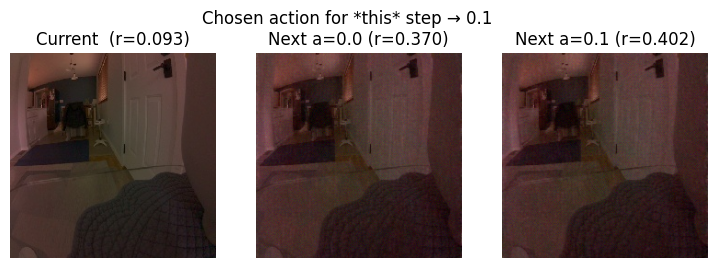

DEBUG:JetBotClient:Cleaning up connection
DEBUG:JetBotClient:Sending motor command: left=0, right=0
DEBUG:JetBotClient:Command sent successfully
INFO:JetBotClient:Cleanup completed



KeyboardInterrupt – exiting loop.
Finished after 1 steps (48.0s).


In [8]:
print("Starting Continuous MPC Control Loop (interactive)…")

observation_buffer   = deque(maxlen=NUM_PREV_FRAMES + 1)
visualization_buffer = deque(maxlen=VISUALIZATION_BUFFER_SIZE)

# --- bootstrap buffer -------------------------------------------------------
print(f"Collecting {NUM_PREV_FRAMES + 1} initial observations …")
while len(observation_buffer) < NUM_PREV_FRAMES + 1:
    obs = get_observation_real()
    if obs is not None:
        observation_buffer.append(obs)
        visualization_buffer.append(obs.cpu().numpy())
        print(f"  {len(observation_buffer)}/{NUM_PREV_FRAMES + 1}")
    time.sleep(0.05)

# --- interactive MPC loop ---------------------------------------------------
step_count    = 0
start_wall_ts = time.time()

try:
    while True:
        step_count += 1
        print(f"\n─── Step {step_count} ───")
    
        # 1. Plan action
        best_action, (rew0, rew1) = choose_best_action(world_model, list(observation_buffer))
    
        # 2. Estimate reward for current and predicted frames
        curr_obs     = observation_buffer[-1]
        curr_reward  = clip_reward_single(curr_obs)
    
        pred_tensor_0 = sample_next_obs(world_model, observation_buffer, DISCRETE_ACTIONS[0])
        pred_tensor_1 = sample_next_obs(world_model, observation_buffer, DISCRETE_ACTIONS[1])
        pred_rew_0    = clip_reward_single(pred_tensor_0)
        pred_rew_1    = clip_reward_single(pred_tensor_1)
    
        # 3. Display for review
        review_step(curr_obs, curr_reward, (pred_tensor_0, pred_tensor_1), (pred_rew_0, pred_rew_1), best_action)
    
        # 4. Apply action
        apply_action_real(best_action)
    
        # 5. Observe next real frame
        next_obs = get_observation_real()
        if next_obs is not None:
            observation_buffer.append(next_obs)
            visualization_buffer.append(next_obs.cpu().numpy())
        else:
            logger.warning("Failed to grab frame after action.")

except KeyboardInterrupt:
    print("\nKeyboardInterrupt – exiting loop.")
finally:
    if remote_robot:
        remote_robot.cleanup()
    print(f"Finished after {step_count} steps "
          f"({time.time()-start_wall_ts:.1f}s).")